# Завдання 2

Обчислення ймовірності чотирьма способами із дослідженням швидкості збіжності, тобто кількості реалізацій, витрачених різними алгоритмами на побудову оцінки із заданими достовірністю та відносною похибкою. Потрібно обчислити наступну ймовірність
$$
Q(\alpha) = \mathbb{P}(\xi_\alpha < \eta),
$$
де $\xi_\alpha$, $\eta$ – незалежні в.в., які мають функції розподілу (ф.р.) $F_\alpha(x)$ та $G(x)$ відповідно.

$$
F_\alpha(u)=1-e^{-(\alpha u)^4}, \quad G(u)=1-e^{-u^2}, \quad u \geq 0
$$

Тоді
$$
Q(\alpha)=\int_0^\infty F_\alpha(u)dG(u) = \int_0^\infty (1-e^{-(\alpha u)^4})2ue^{-u^2}du
$$


В усіх наведених вище випадках обчислення вести із достовірністю $0.99$ та відносною похибкою $1\%$, тобто $z=2.575$ і $\varepsilon=0.01$. 

Розглядаються три можливі значення параметра $\alpha = 1, 0.3, 0.1$. 

Потрібно виконати наступні завдання.

## A. При кожному $\alpha =1; 0.3; 0.1$ обчислити точне значення ймовірності $Q(\alpha)$

## B. Стандартний метод Монте-Карло (метод 1)
$Q(\alpha) = \mathbb M I(\xi_\alpha < \eta), \text{ тобто } \hat{q}_i = I( \xi_\alpha^{(i)} < \eta_i ), \text{ де } I(\cdot) \text{ – індикаторна функція.}$

## C. Метод 2
$$
Q(\alpha)=\int_0^\infty F_\alpha(u)dG(u)=F_\alpha(u)G(u)\big\vert^\infty_0-\int_0^\infty G(u)dF_\alpha(u)=1-\int_0^\infty G(u)dF_\alpha(u)=\int_0^\infty dF_\alpha(u)-\int_0^\infty G(u)dF_\alpha(u)=\int_0^\infty \left[1-G(u)\right]dF_\alpha(u)=\mathbb M\left[1-G(\xi_\alpha)\right]
$$
тобто
$\hat{q}_i = 1-G(\xi_\alpha^{(i)})=e^{-[\xi_\alpha^{(i)}]^2}$

## D. Метод 3
$$
Q(\alpha)=\int_0^\infty F_\alpha(u)dG(u)= \mathbb M F_\alpha(\eta)
$$
тобто
$\hat{q}_i = F_\alpha(\eta^{(i)})=1-e^{-(\alpha \eta^{(i)})^4}$

## E. Метод 4
$$
Q(\alpha)=\int_0^\infty F_\alpha(u)dG(u)=\int_0^\infty F_\alpha(u)g(u)du=\int_0^\infty F_\alpha(u)\frac{g(u)}{h_\alpha(u)}h_\alpha(u)du=\mathbb M \left[F_\alpha(\gamma_\alpha)\frac{g(\gamma_\alpha)}{h_\alpha(\gamma_\alpha)}\right]
$$
де $\gamma_\alpha$ – невід'ємна в.в. з щільністю $h_\alpha(u)$.

$h_\alpha(u)=u^5e^{-u^2}\\
\gamma_\alpha =\sqrt{\theta^{(1)}+\theta^{(2)}+\theta^{(3)}}, \quad \theta^{(i)}\sim Exp(1)$

тобто
$$\hat{q_i}=\left[1-e^{-(\alpha \beta_i)^4}\right]\frac{2\beta_i e^{-\beta_i^2}}{\beta_i^5 e^{-\beta_i^2}}=\frac{2}{\beta_i^4}\left[1-e^{-(\alpha \beta_i)^4}\right]$$
де $\beta_i=\sqrt{\theta_i^{(1)}+\theta_i^{(2)}+\theta_i^{(3)}}$

In [1]:
import numpy as np
import math
from scipy import stats
from scipy import integrate 

In [2]:
def exact_Q(alpha):
    """Обчислення точного значення Q(alpha) згідно з формулою."""
    # Для числової стабільності, якщо alpha дуже мале, можна використати асимптотику 2*alpha^4
    integrand = lambda u, alpha: (1 - np.exp(-(alpha * u)**4)) * 2 * u * np.exp(-u**2)
    res, _ = integrate.quad(integrand, 0, np.inf, args=(alpha,))
    return res

    
alpha_lst = [1, 0.3, 0.1]

for alpha in alpha_lst:
    print(f"Q({alpha}) = {exact_Q(alpha)}")

Q(1) = 0.45435863923495345
Q(0.3) = 0.015470119571053638
Q(0.1) = 0.00019988011983236367


In [3]:
from numba import njit, prange

@njit(parallel=True, fastmath=True)
def method1(alpha, n_sim):
    U1 = np.random.random(n_sim)
    U2 = np.random.random(n_sim)
    xi = (-np.log(U1))**(1/4) / alpha
    eta = np.sqrt(-np.log(U2))
    return xi < eta

@njit(parallel=True, fastmath=True)
def method2(alpha, n_sim):
    U = np.random.random(n_sim)
    xi = (-np.log(U))**(1/4) / alpha
    return np.exp(-xi**2)

@njit(parallel=True, fastmath=True)
def method3(alpha, n_sim):
    U = np.random.random(n_sim)
    eta = (-np.log(U))**(1/2)
    return 1 - np.exp(- (alpha * eta)**4)

@njit(parallel=True, fastmath=True)
def method4(alpha, n_sim):
    U1 = np.random.random(n_sim)
    U2 = np.random.random(n_sim)
    U3 = np.random.random(n_sim)
    
    theta1 = -np.log(U1)
    theta2 = -np.log(U2)
    theta3 = -np.log(U3)
    beta = np.sqrt(theta1 + theta2 + theta3)
    
    q_i = (2 / beta**4) * (1 - np.exp(- (alpha * beta)**4))
    return q_i

In [4]:
def simulation_Q(alpha, method, z_gamma=2.575, epsilon=0.01, n0=2, batch_size=1, max_total=1e10):
    total_n = 0
    sum_q = 0.0
    sum_q2 = 0.0
    
    # Функція для оновлення статистик
    def update_stats(n_new, q_new):
        nonlocal total_n, sum_q, sum_q2
        total_n += n_new
        sum_q += np.sum(q_new)
        sum_q2 += np.sum(q_new**2)
    
    # Початковий блок
    for _ in range(math.ceil(n0 / batch_size)):
        n_sim = min(batch_size, n0 - total_n)
        if n_sim <= 0:
            break
        q = method(alpha, n_sim)
        update_stats(n_sim, q)
    
    # Обчислюємо поточну оцінку та вибіркову дисперсію
    Q_hat = sum_q / total_n
    if total_n > 1:
        sigma2_hat = (sum_q2 - total_n * Q_hat**2) / (total_n - 1)
    else:
        sigma2_hat = 0.0
    
    # Обчислюємо необхідну загальну кількість симуляцій
    if Q_hat == 0:
        n_req = max_total  # Щоби уникнути ділення на нуль
    else:
        n_req = math.ceil(z_gamma**2 * sigma2_hat / (epsilon**2 * Q_hat**2))
    
    # Симулюємо додаткові партії, якщо потрібно
    while total_n < n_req:
        # Перевірка на максимум симуляцій
        if total_n >= max_total:
            print(f"Попередження: досягнуто максимальну кількість симуляцій = {max_total}.")
            break
        n_sim = min(batch_size, n_req - total_n)
        q = method(alpha, n_sim)
        update_stats(n_sim, q)
        
        # Оновлюємо оцінку та дисперсію та перераховуємо n_req
        Q_hat = sum_q / total_n
        if total_n > 1:
            sigma2_hat = (sum_q2 - total_n * Q_hat**2) / (total_n - 1)
        else:
            sigma2_hat = 0.0
        if Q_hat != 0:
            n_req = math.ceil(z_gamma**2 * sigma2_hat / (epsilon**2 * Q_hat**2))
        else:
            n_req = max_total  # якщо поки що Q_hat==0
        
    # Стандартова помилка та довірчий інтервал
    std_error = math.sqrt(sigma2_hat / total_n) if total_n > 0 else 0.0
    conf_interval = (Q_hat - z_gamma * std_error, Q_hat + z_gamma * std_error)
    
    return Q_hat, sigma2_hat, conf_interval, total_n

In [5]:
# ---------------------------
# Головна частина: запускаємо для α = 1, 0.3, 0.1
# ---------------------------

alphas = [1, 0.3, 0.1]
methods = [method1, method2, method3, method4]
z = stats.norm.ppf(0.995)
for i, f in enumerate(methods):
    print(f"Метод_{i+1}", "="*60)
    for alpha in alphas:  
        print("="*30)
        print(f"Параметр alpha = {alpha}")
        

        Q_exact = exact_Q(alpha)
        print(f"Точне значення Q(alpha) = {Q_exact:.6e}")
        
        Q_hat, sigma2_hat, conf_int, n_total = simulation_Q(alpha, method=f, z_gamma = z, batch_size=10000, n0=100)
        print(f"Оцінка Q(alpha) методом MC      = {Q_hat:.6e}")
        print(f"Вибіркова дисперсія             = {sigma2_hat:.6e}")
        print(f"Довірчий інтервал (99%%)         = [{conf_int[0]:.6e}, {conf_int[1]:.6e}]")
        print(f"Кількість симуляцій (реалізацій) = {n_total}")
        
        print("\n")
    print("="*60)

Метод_1 ============================================================
Параметр alpha = 1
Точне значення Q(alpha) = 4.543586e-01
Оцінка Q(alpha) методом MC      = 4.549180e-01
Вибіркова дисперсія             = 2.479707e-01
Довірчий інтервал (99%%)         = [4.503771e-01, 4.594590e-01]
Кількість симуляцій (реалізацій) = 79788


Параметр alpha = 0.3
Точне значення Q(alpha) = 1.547012e-02
Оцінка Q(alpha) методом MC      = 1.541792e-02
Вибіркова дисперсія             = 1.518021e-02
Довірчий інтервал (99%%)         = [1.526374e-02, 1.557210e-02]
Кількість симуляцій (реалізацій) = 4237147


Параметр alpha = 0.1
Точне значення Q(alpha) = 1.998801e-04
Оцінка Q(alpha) методом MC      = 1.998291e-04
Вибіркова дисперсія             = 1.997892e-04
Довірчий інтервал (99%%)         = [1.978308e-04, 2.018274e-04]
Кількість симуляцій (реалізацій) = 331968648


Метод_2 ============================================================
Параметр alpha = 1
Точне значення Q(alpha) = 4.543586e-01
Оцінка Q(alpha) м

In [8]:
from matplotlib import pyplot as plt
import numpy as np

In [6]:
@njit(parallel=True, fastmath=True)
def method1(alpha, n_sim):
    U1 = np.random.random(n_sim)
    U2 = np.random.random(n_sim)
    xi = (-np.log(U1))**(1/4) / alpha
    eta = np.sqrt(-np.log(U2))
    return xi < eta

@njit(parallel=True, fastmath=True)
def method2(alpha, n_sim):
    U = np.random.random(n_sim)
    xi = (-np.log(U))**(1/4) / alpha
    return np.exp(-xi**2)

@njit(parallel=True, fastmath=True)
def method3(alpha, n_sim):
    U = np.random.random(n_sim)
    eta = (-np.log(U))**(1/2)
    return 1 - np.exp(- (alpha * eta)**4)

@njit(parallel=True, fastmath=True)
def method4(alpha, n_sim):
    U1 = np.random.random(n_sim)
    U2 = np.random.random(n_sim)
    U3 = np.random.random(n_sim)
    
    theta1 = -np.log(U1)
    theta2 = -np.log(U2)
    theta3 = -np.log(U3)
    beta = np.sqrt(theta1 + theta2 + theta3)
    
    q_i = (2 / beta**4) * (1 - np.exp(- (alpha * beta)**4))
    return q_i

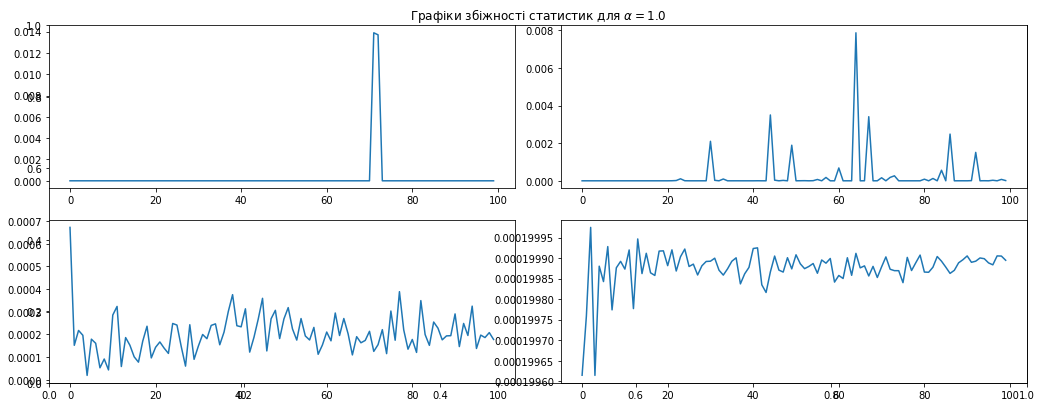

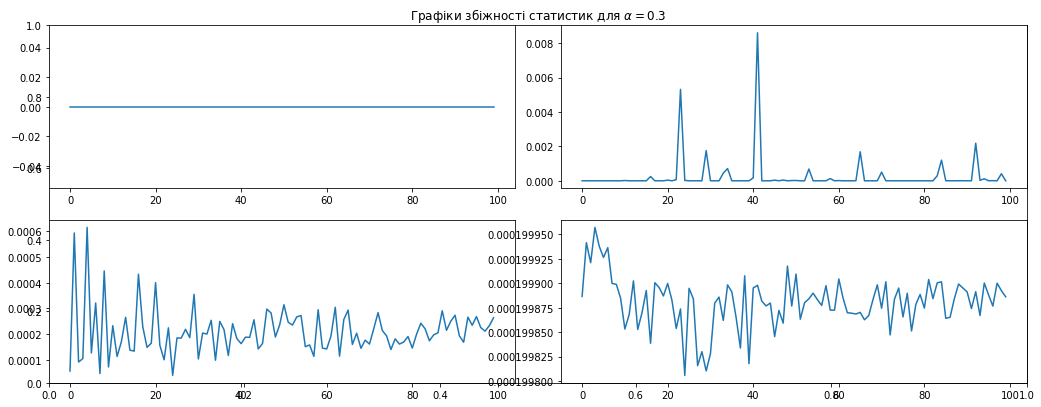

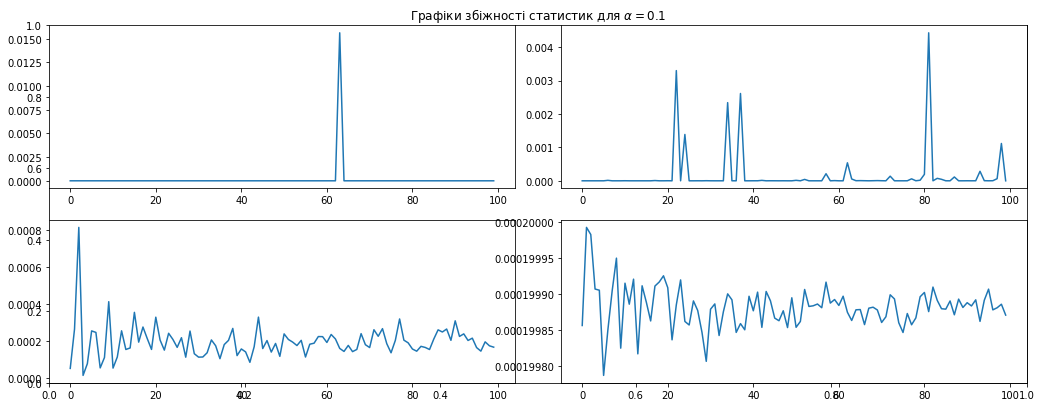

In [9]:
for alpha in [1., 0.3, 0.1]:
    fig = plt.figure(figsize=(15, 6))
    plt.title(r"Графіки збіжності статистик для $\alpha=$%.1f" % alpha)
    for i, method in enumerate([method1, method2, method3, method4]):
        q_list = [0] * 100
        for n0 in range(100):
            q_list[n0] = method(0.1, n0+1).mean()
        plt.subplot(2, 2, i+1)
        plt.tight_layout()
        plt.plot(q_list)
    plt.show()

З гафіків видно, що
- для $\alpha=1$ приблизні значення $n_0$ для відповідних методів будуть рівні $[80, 100, 20, 25]$,

- для $\alpha=0.3$ приблизні значення $n_0$ для відповідних методів будуть рівні $[1, 100, 20, 20]$,

- для $\alpha=0.1$ приблизні значення $n_0$ для відповідних методів будуть рівні $[90, 80, 30, 30]$,

---